Dataset: energy demand in the UK from 2009 to 2024 + energy generation by source in the UK from 2009 to 2024

Business: we are an energy trading company specializing in the intraday and day-ahead markets. We operate at narrow profit margins, relying on accurate predictions of energy demand.

Problem: Our current ML model (baseline) works, but its predictions show significant 

Solution: Develop more advanced model. Test what additional features could improve the forecast in 0 - 48 hour window year-round.

Step by step solution:

1. Load, parse and join the datasets for demand and generation of electricity in the UK (2009-2024)
2. Explore the data, visualize it and find trends
3. Define baseline forecasting model, outline its features and make baseline forecast up to 48 hours into the future
4. Explore what additional features could improve the model prediction 
5. Compare the two models using ]]]] metric
6. Hypothesize what additional data could improve the forecast

In [2]:
import os
import shutil
import requests
import kagglehub
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt

from datetime import timedelta


# Download all files from Kaggle dataset
path = kagglehub.dataset_download("albertovidalrod/electricity-consumption-uk-20092022")
print("Path to dataset files:", path)

# Copy historic_demand_2009_2024.csv to notebook folder
csv_name = "historic_demand_2009_2024.csv"
src = os.path.join(path, csv_name)
dst = os.path.join(os.getcwd(), csv_name)
shutil.copy(src, dst)
print(f"Copied {csv_name} to notebook folder: {dst}")

# Read CSV directly with Polars
df_dmnd = pl.read_csv(dst)

# Calculate datetime for each settlement_period (1-48, each is a 30-min interval)
df_dmnd = df_dmnd.with_columns(
    (pl.col('settlement_date') + " " + pl.format("{}:{}", 
        ((pl.col('settlement_period') - 1) * 30 // 60).cast(pl.Utf8).str.zfill(2),
        ((pl.col('settlement_period') - 1) * 30 % 60).cast(pl.Utf8).str.zfill(2)
    )).str.strptime(pl.Datetime, "%Y-%m-%d %H:%M", strict=False).alias('datetime')
)

# Drop rows where datetime is null (due to day-time saving time issues)
df_dmnd = df_dmnd.filter(pl.col('datetime').is_not_null())

# Sort by datetime (Polars does not have a true index)
df_dmnd = df_dmnd.sort('datetime')

# Drop unwanted columns
cols_to_drop = ["settlement_period", "settlement_date", ""] 
df_dmnd = df_dmnd.drop(cols_to_drop)

cols = ['datetime'] + [col for col in df_dmnd.columns if col != 'datetime']
df_dmnd = df_dmnd.select(cols)

print("Demand DataFrame columns:", df_dmnd.columns)
print(df_dmnd.head(10))



/Users/vadimbogatyr/VSCode/adaptfy_uk_energy/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



Path to dataset files: /Users/vadimbogatyr/.cache/kagglehub/datasets/albertovidalrod/electricity-consumption-uk-20092022/versions/85
Copied historic_demand_2009_2024.csv to notebook folder: /Users/vadimbogatyr/VSCode/adaptfy_uk_energy/historic_demand_2009_2024.csv
Demand DataFrame columns: ['datetime', 'nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow', 'scottish_transfer', 'viking_flow', 'greenlink_flow', 'is_holiday']
shape: (10, 22)
┌─────────────┬───────┬───────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ datetime    ┆ nd    ┆ tsd   ┆ england_wa ┆ … ┆ scottish_t ┆ viking_flo ┆ greenlink_ ┆ is_holiday │
│ ---         ┆ ---   ┆ ---   ┆ les_demand ┆   ┆ ransfer    ┆ w          ┆ flow       ┆ ---        │
│ dateti

In [3]:
# NESO energy generation mix resource_id from the example
resource_id = "f93d1835-75bc-43e5-84ad-12472b180a98"

# CKAN API endpoint
url = "https://api.neso.energy/api/3/action/datastore_search"

# Query parameters
params = {
    "resource_id": resource_id,
    "limit": 500000  # Adjust limit as needed
}

response = requests.get(url, params=params)
data = response.json()

# Convert records to Polars DataFrame
records = data['result']['records']
df_gnrt = pl.DataFrame(records)

# Parse DATETIME to polars datetime
df_gnrt = df_gnrt.with_columns(
    pl.col("DATETIME").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S", strict=False).alias("datetime")
)

# Split into date and time columns
df_gnrt = df_gnrt.with_columns([
    pl.col("datetime").dt.strftime("%Y-%m-%d").alias("date"),
    pl.col("datetime").dt.strftime("%H:%M").alias("time")
])

# Drop 'DATETIME', '_id', and any Unnamed columns
cols_to_drop = ["DATETIME", "_id", "date", "time"]
df_gnrt = df_gnrt.drop(cols_to_drop)

# Lowercase all column names
df_gnrt.columns = [col.lower() for col in df_gnrt.columns]

# Bring 'datetime' to the beginning
df_gnrt = df_gnrt.select(["datetime"] + [col for col in df_gnrt.columns if col != "datetime"])

# Save the processed generation dataframe to a CSV in the same folder as the notebook
output_path = os.path.join(os.getcwd(), "processed_generation.csv")
df_gnrt.write_csv(output_path)
print(f"Saved processed generation data to: {output_path}")

print("Demand DataFrame columns:", df_gnrt.columns)
print(df_gnrt.head(10))

print("Dataframe shape:", df_gnrt.shape)

Saved processed generation data to: /Users/vadimbogatyr/VSCode/adaptfy_uk_energy/processed_generation.csv
Demand DataFrame columns: ['datetime', 'gas', 'coal', 'nuclear', 'wind', 'wind_emb', 'hydro', 'imports', 'biomass', 'other', 'solar', 'storage', 'generation', 'carbon_intensity', 'low_carbon', 'zero_carbon', 'renewable', 'fossil', 'gas_perc', 'coal_perc', 'nuclear_perc', 'wind_perc', 'wind_emb_perc', 'hydro_perc', 'imports_perc', 'biomass_perc', 'other_perc', 'solar_perc', 'storage_perc', 'generation_perc', 'low_carbon_perc', 'zero_carbon_perc', 'renewable_perc', 'fossil_perc']
shape: (10, 34)
┌─────────────┬────────┬──────┬─────────┬───┬─────────────┬─────────────┬─────────────┬────────────┐
│ datetime    ┆ gas    ┆ coal ┆ nuclear ┆ … ┆ low_carbon_ ┆ zero_carbon ┆ renewable_p ┆ fossil_per │
│ ---         ┆ ---    ┆ ---  ┆ ---     ┆   ┆ perc        ┆ _perc       ┆ erc         ┆ c          │
│ datetime[μs ┆ f64    ┆ f64  ┆ f64     ┆   ┆ ---         ┆ ---         ┆ ---         ┆ --- 

In [4]:
# Merge the two dataframes on 'datetime'
df = df_dmnd.join(df_gnrt, on=["datetime"], how="inner")


# Print the column names and the header
print("Columns in the new dataframe: ", df.columns)
print(df.head())


Columns in the new dataframe:  ['datetime', 'nd', 'tsd', 'england_wales_demand', 'embedded_wind_generation', 'embedded_wind_capacity', 'embedded_solar_generation', 'embedded_solar_capacity', 'non_bm_stor', 'pump_storage_pumping', 'ifa_flow', 'ifa2_flow', 'britned_flow', 'moyle_flow', 'east_west_flow', 'nemo_flow', 'nsl_flow', 'eleclink_flow', 'scottish_transfer', 'viking_flow', 'greenlink_flow', 'is_holiday', 'gas', 'coal', 'nuclear', 'wind', 'wind_emb', 'hydro', 'imports', 'biomass', 'other', 'solar', 'storage', 'generation', 'carbon_intensity', 'low_carbon', 'zero_carbon', 'renewable', 'fossil', 'gas_perc', 'coal_perc', 'nuclear_perc', 'wind_perc', 'wind_emb_perc', 'hydro_perc', 'imports_perc', 'biomass_perc', 'other_perc', 'solar_perc', 'storage_perc', 'generation_perc', 'low_carbon_perc', 'zero_carbon_perc', 'renewable_perc', 'fossil_perc']
shape: (5, 55)
┌─────────────┬───────┬───────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ datetime    ┆ nd    ┆ tsd

In [79]:
from datetime import datetime
import plotly.graph_objects as go

df = df.sort("datetime")

# Polars equivalent of pandas resample for time-based grouping
hourly_avg = (
    df.group_by_dynamic("datetime", every="1h")
      .agg([pl.col("nd").mean(), pl.col("tsd").mean(), pl.col("generation").mean()])
      .sort("datetime")
)
daily_avg = (
    df.group_by_dynamic("datetime", every="1d")
      .agg([pl.col("nd").mean(), pl.col("tsd").mean(), pl.col("generation").mean()])
      .sort("datetime")
)
weekly_avg = (
    df.group_by_dynamic("datetime", every="1w")
      .agg([pl.col("nd").mean(), pl.col("tsd").mean(), pl.col("generation").mean()])
      .sort("datetime")
)
monthly_avg = (
    df.group_by_dynamic("datetime", every="1mo")
      .agg([pl.col("nd").mean(), pl.col("tsd").mean(), pl.col("generation").mean()])
      .sort("datetime")
)
yearly_avg = (
    df.group_by_dynamic("datetime", every="1y")
      .agg([pl.col("nd").mean(), pl.col("tsd").mean(), pl.col("generation").mean()])
      .sort("datetime")
)

hourly_start = datetime(2023, 7, 1, 0, 0)
hourly_end = datetime(2023, 12, 31, 23, 59)

daily_start = datetime(2023, 1, 1, 0, 0)
daily_end = datetime(2023, 12, 31, 23, 59)

weekly_start = datetime(2018, 1, 1, 0, 0)
weekly_end = datetime(2023, 12, 31, 23, 59)

monthly_start = datetime(2009, 1, 3, 0, 0)
monthly_end = datetime(2023, 12, 31, 23, 59)

yearly_start = datetime(2009, 1, 3, 0, 0)
yearly_end = datetime(2023, 12, 31, 23, 59)

def plot_avg_plotly(
    df_avg,
    x_col,
    start,
    end,
    title,
    xlabel,
    marker_size,
    line_style,
    nd_color='bisque',
    tsd_color='darkorange',
    gen_color='dodgerblue'
):
    
    # Filter the dataframe based on the provided start and end datetime
    df_avg = df_avg.filter((pl.col(x_col) >= start) & (pl.col(x_col) <= end))

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_avg[x_col],
        y=df_avg['nd'],
        mode=line_style,
        name='National Demand (ND)',
        marker=dict(size=marker_size, color=nd_color),
        line=dict(color=nd_color)
    ))
    fig.add_trace(go.Scatter(
        x=df_avg[x_col],
        y=df_avg['tsd'],
        mode=line_style,
        name='Transmission System Demand (TSD)',
        marker=dict(size=marker_size, color=tsd_color),
        line=dict(color=tsd_color)
    ))
    fig.add_trace(go.Scatter(
        x=df_avg[x_col],
        y=df_avg['generation'],
        mode=line_style,
        name='Generation',
        marker=dict(size=marker_size, color=gen_color),
        line=dict(color=gen_color)
    ))
    fig.update_layout(
        title=dict(text=title, font=dict(size=20), x=0.5),
        xaxis_title=xlabel,
        yaxis_title='MW',
        yaxis=dict(range=[0, 60000], title_font=dict(size=18), tickfont=dict(size=16)),
        xaxis=dict(title_font=dict(size=18), tickfont=dict(size=16)),
        legend=dict(font=dict(size=15), x=0, y=0, xanchor='left', yanchor='bottom'),
        width=1100,
        height=500,
        plot_bgcolor='white'
    )
    fig.show()

# Usage for each aggregation:
plot_avg_plotly(df, 'datetime', hourly_start, hourly_end, 'Hourly Average Electricity Demand and Generation in the UK during H2 2023', 'Hour', marker_size=2, line_style='markers')
plot_avg_plotly(daily_avg, 'datetime', daily_start, daily_end, 'Daily Average Electricity Demand and Generation in the UK during 2023', 'Date', marker_size=4, line_style='lines+markers')
plot_avg_plotly(weekly_avg, 'datetime', weekly_start, weekly_end, 'Weekly Average Electricity Demand and Generation in the UK from 2018 to 2023', 'Week', marker_size=3, line_style='lines+markers')
plot_avg_plotly(monthly_avg, 'datetime', monthly_start, monthly_end, 'Monthly Average Electricity Demand and Generation in the UK from 2009 to 2024', 'Month', marker_size=4, line_style='lines+markers')
plot_avg_plotly(yearly_avg, 'datetime', yearly_start, yearly_end, 'Yearly Average Electricity Demand and Generation in the UK from 2009 to 2024', 'Year', marker_size=6, line_style='lines+markers')

Now, we define our baseline model

/var/folders/44/ht9jzlhn6k7cx0_d2g65xfpm0000gn/T/ipykernel_72405/1732314953.py:48: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



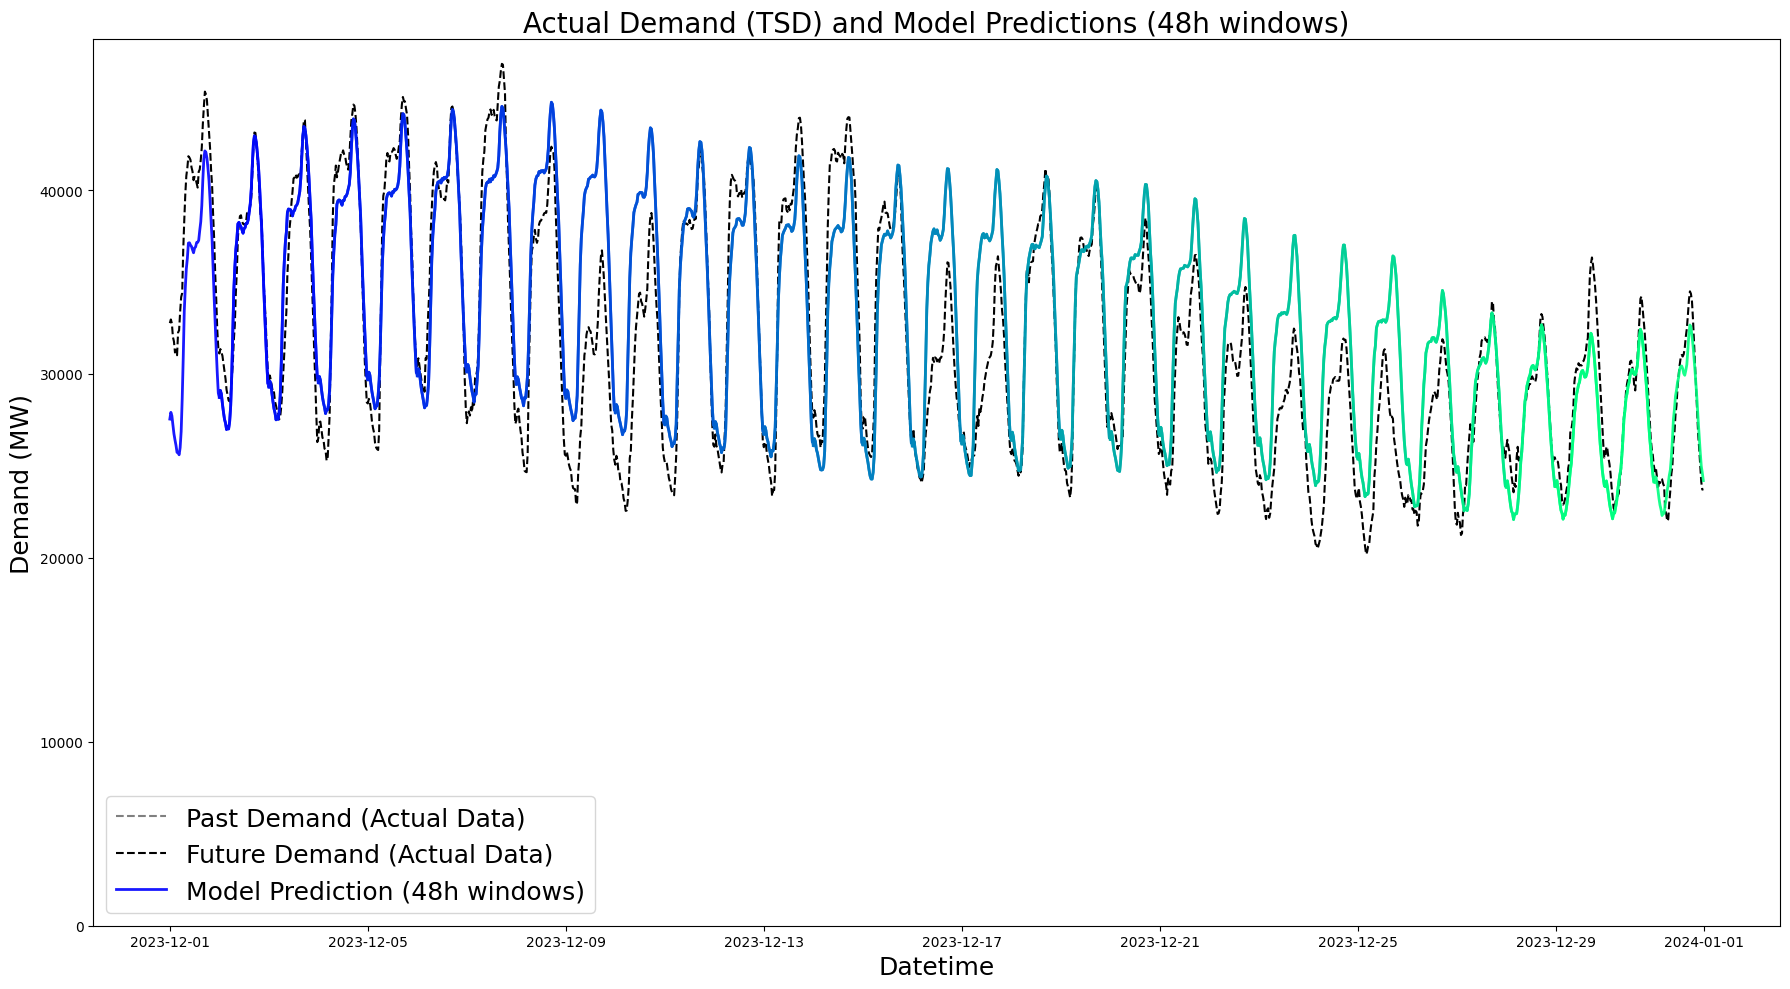

Test RMSE: 2840.05 MW


In [21]:
# Baseline: 7-day mean of demand at the same time of day

import matplotlib.cm as cm
import numpy as np
from datetime import datetime
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error

# Preparing the data (30 minute resolution)
df_ml = df.select([
    pl.col("datetime"),
    pl.col("tsd"),
    pl.col("is_holiday")  # include if you want to use it later
])

# Define test period
test_start = datetime(2023, 12, 1, 0, 0)
test_end = datetime(2023, 12, 31, 23, 59)

# Get the full actual data for plotting (from 1st Dec to test_end)
plot_start = datetime(2023, 12, 1, 0, 0)
plot_end = test_end

actual_past_mask = (df_ml["datetime"] >= plot_start) & (df_ml["datetime"] < test_start)
actual_past_times = df_ml.filter(actual_past_mask)["datetime"].to_pandas()
actual_past_tsd = df_ml.filter(actual_past_mask)["tsd"].to_numpy()

actual_future_mask = (df_ml["datetime"] >= test_start) & (df_ml["datetime"] <= test_end)
actual_future_times = df_ml.filter(actual_future_mask)["datetime"].to_pandas()
actual_future_tsd = df_ml.filter(actual_future_mask)["tsd"].to_numpy()

plt.figure(figsize=(18, 10))
plt.plot(actual_past_times, actual_past_tsd, label="Past Demand (Actual Data)", color="grey", linestyle='--', zorder=1)
plt.plot(actual_future_times, actual_future_tsd, label="Future Demand (Actual Data)", color="black", linestyle='--', zorder=1)

results = []

# Count how many 48h windows fit in the test period with 24h step to set colormap
rolling_test_start = test_start
window_count = 0
while rolling_test_start + pd.Timedelta(hours=48) <= test_end:
    window_count += 1
    rolling_test_start += pd.Timedelta(hours=24)

rolling_test_start = test_start
cmap = cm.get_cmap('winter', window_count)
i = 0
prediction_handle = None

while rolling_test_start + pd.Timedelta(hours=24) <= test_end:
    test_mask = (df_ml["datetime"] >= rolling_test_start) & (df_ml["datetime"] < rolling_test_start + pd.Timedelta(hours=48))
    test_df = df_ml.filter(test_mask)
    times = test_df["datetime"].to_pandas()
    y_test = test_df["tsd"].to_numpy()

    baseline_pred = []
    for dt in times:
        # Use Polars to filter for the rolling 7-day window at the same hour/minute
        mask = (
            (df_ml["datetime"] < dt) &
            (df_ml["datetime"] >= dt - pd.Timedelta(days=7)) &
            (df_ml["datetime"].dt.hour() == dt.hour) &
            (df_ml["datetime"].dt.minute() == dt.minute)
        )
        vals = df_ml.filter(mask)["tsd"].to_numpy()
        baseline_pred.append(np.nanmean(vals) if len(vals) > 0 else np.nan)
    baseline_pred = np.array(baseline_pred)

    rmse = root_mean_squared_error(y_test, baseline_pred)
    results.append({"test_start": rolling_test_start, "rmse": rmse})

    # Plot and capture handle for legend
    if i == 0:
        prediction_handle, = plt.plot(times, baseline_pred, color=cmap(i), linewidth=2, alpha=0.9, zorder=2)
    else:
        plt.plot(times, baseline_pred, color=cmap(i), linewidth=2, alpha=0.9, zorder=2)
    rolling_test_start += pd.Timedelta(hours=24)
    i += 1

# Custom legend
handles = [
    plt.Line2D([], [], color="grey", linestyle='--', label="Past Demand (Actual Data)"),
    plt.Line2D([], [], color="black", linestyle='--', label="Future Demand (Actual Data)"),
    prediction_handle
]
labels = [
    "Past Demand (Actual Data)",
    "Future Demand (Actual Data)",
    "Model Prediction (48h windows)"
]
plt.legend(handles, labels, loc='lower left', fontsize=18)
plt.title("Actual Demand (TSD) and Model Predictions (48h windows)", fontsize=20)
plt.ylim(bottom=0)
plt.xlabel("Datetime", fontsize=18)
plt.ylabel("Demand (MW)", fontsize=18)
plt.tight_layout()
plt.show()

# Print results DataFrame
results_7_day_mean = pd.DataFrame(results)
print(f"Test RMSE: {results_7_day_mean['rmse'].mean():.2f} MW")

Number of 48h windows in test period: 30


/var/folders/44/ht9jzlhn6k7cx0_d2g65xfpm0000gn/T/ipykernel_72405/2397073431.py:61: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



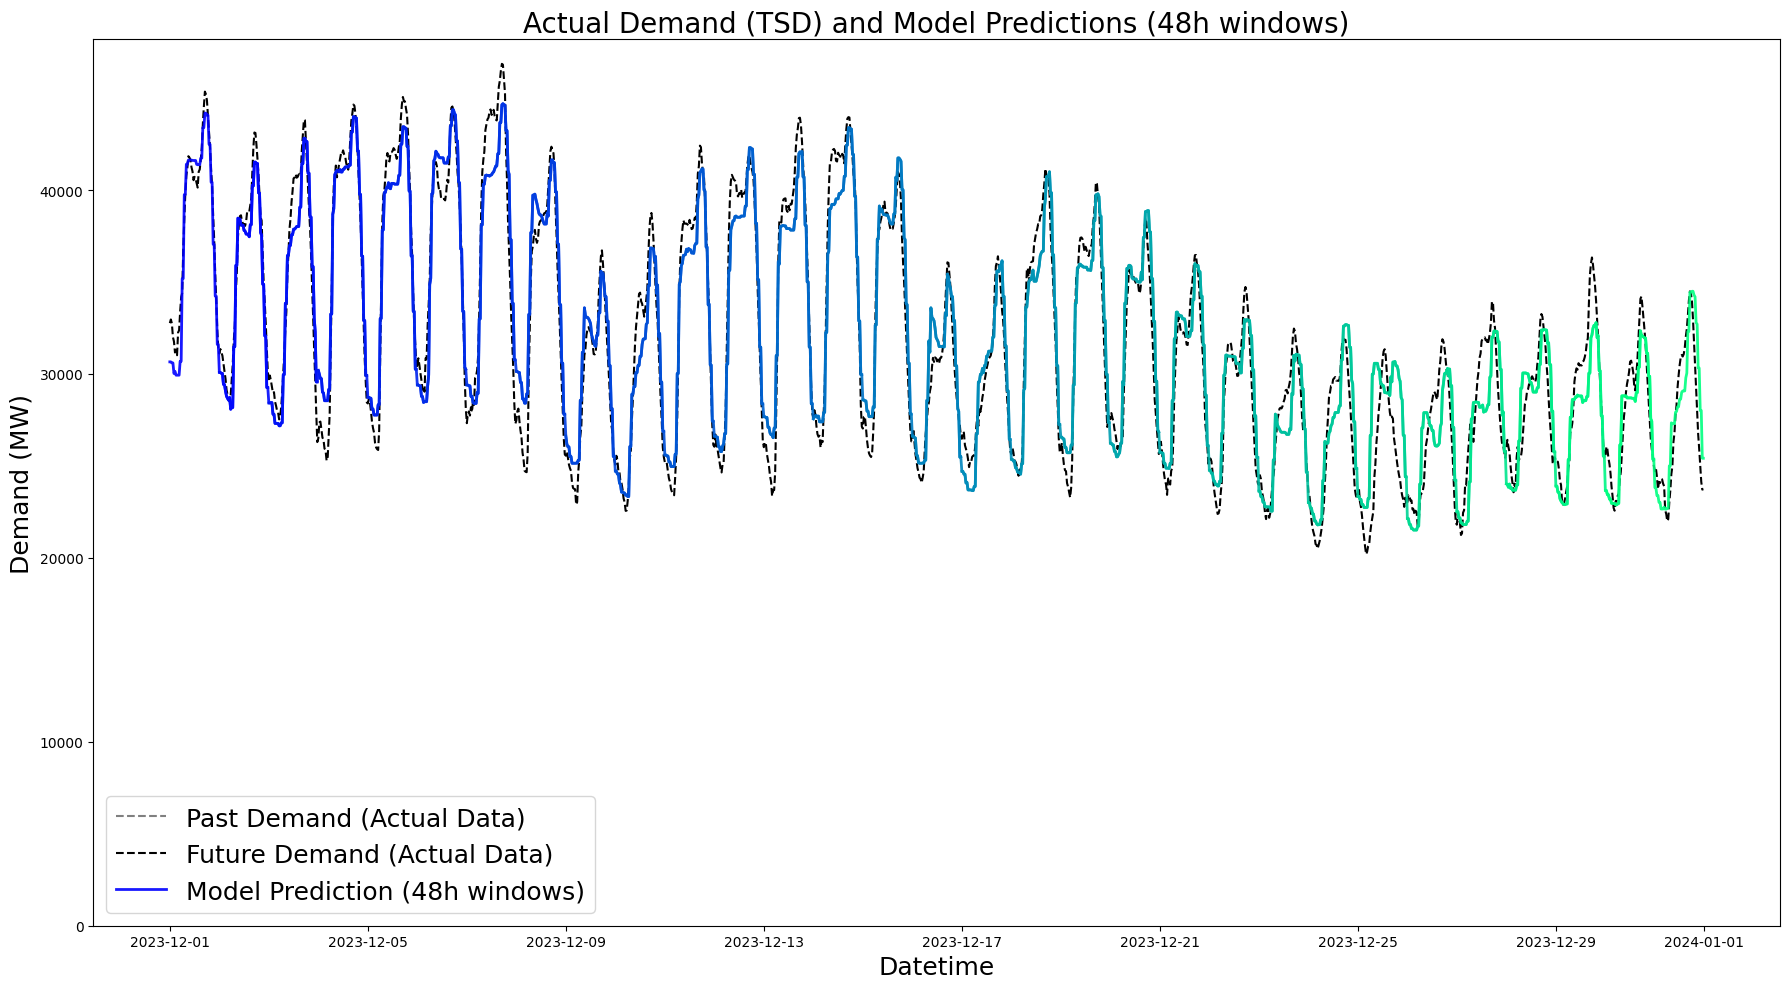

Test RMSE: 1698.50 MW


In [22]:
# Machine Learning Model: GradientBoostingRegressor with 3 features

import matplotlib.cm as cm
import numpy as np
from datetime import datetime
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error

# Prepare features for ML
df_ml = (
    df.with_columns([
        pl.col("datetime"),
        pl.col("tsd"),
        pl.col("datetime").dt.weekday().alias("day_of_week"),      # 0=Monday, 6=Sunday
        pl.col("datetime").dt.hour().alias("hour"),     
        pl.col("tsd").rolling_mean(window_size=48).alias("demand_rolling_mean_24h")
    ])
)

# Define test period
train_start = datetime(2020, 1, 1, 0, 0)
test_start = datetime(2023, 12, 1, 0, 0)
test_end = datetime(2023, 12, 31, 23, 59)

# Get the full actual data for plotting (from 1st Dec to test_end)
plot_start = datetime(2023, 12, 1, 0, 0)
plot_end = test_end

actual_past_mask = (df_ml["datetime"] >= plot_start) & (df_ml["datetime"] < test_start)
actual_past_times = df_ml.filter(actual_past_mask)["datetime"].to_pandas()
actual_past_tsd = df_ml.filter(actual_past_mask)["tsd"].to_numpy()

actual_future_mask = (df_ml["datetime"] >= test_start) & (df_ml["datetime"] <= test_end)
actual_future_times = df_ml.filter(actual_future_mask)["datetime"].to_pandas()
actual_future_tsd = df_ml.filter(actual_future_mask)["tsd"].to_numpy()

plt.figure(figsize=(18, 10))
plt.plot(actual_past_times, actual_past_tsd, label="Past Demand (Actual Data)", color="grey", linestyle='--', zorder=1)
plt.plot(actual_future_times, actual_future_tsd, label="Future Demand (Actual Data)", color="black", linestyle='--', zorder=1)

# --- Model predictions (GradientBoostingRegressor) ---
features = ["day_of_week", "hour", "demand_rolling_mean_24h"]
target = "tsd"
X = df_ml.select(features)
y = df_ml.select(target)

results = []
prediction_handle = []

# Count how many 48h windows fit in the test period with 24h step to set colormap
rolling_test_start = test_start
window_count = 0

while rolling_test_start + pd.Timedelta(hours=24) < test_end:
    window_count += 1
    rolling_test_start += pd.Timedelta(hours=24)


print ("Number of 48h windows in test period:", window_count)
rolling_test_start = test_start
cmap = cm.get_cmap('winter', window_count)
i = 0
prediction_handle = None


train_mask = (df_ml["datetime"] > train_start) & (df_ml["datetime"] < test_start)
X_train = X.filter(train_mask).to_pandas()
y_train = y.filter(train_mask).to_numpy().ravel()


model = GradientBoostingRegressor(
        n_estimators=100, max_depth=5, learning_rate=0.05, validation_fraction=0.2, random_state=7
    )
model.fit(X_train, y_train)

while rolling_test_start + pd.Timedelta(hours=24) <= test_end:
    train_mask = (df_ml["datetime"] > train_start) & (df_ml["datetime"] < test_start)
    test_mask = (df_ml["datetime"] >= rolling_test_start) & (df_ml["datetime"] < rolling_test_start + pd.Timedelta(hours=48))
    X_test = X.filter(test_mask).to_pandas()
    y_test = y.filter(test_mask).to_numpy().ravel()
    times = df_ml.filter(test_mask)["datetime"].to_numpy()

    if len(X_test) == 0:
        break
    
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    results.append({"test_start": rolling_test_start, "rmse": rmse})
    # Plot and capture handle for legend
    if i == 0:
        prediction_handle, = plt.plot(times, y_pred, color=cmap(i), linewidth=2, alpha=0.9, zorder=2, label="Prediction")
    else:
        plt.plot(times, y_pred, color=cmap(i), linewidth=2, alpha=0.9, zorder=2)
    rolling_test_start += pd.Timedelta(hours=24)
    i += 1

# Custom legend
handles = [
    plt.Line2D([], [], color="grey", linestyle='--', label="Past Demand (Actual Data)"),
    plt.Line2D([], [], color="black", linestyle='--', label="Future Demand (Actual Data)"),
    prediction_handle
]
labels = [
    "Past Demand (Actual Data)",
    "Future Demand (Actual Data)",
    "Model Prediction (48h windows)"
]
plt.legend(handles, labels, loc='lower left', fontsize=18)
plt.title("Actual Demand (TSD) and Model Predictions (48h windows)", fontsize=20)
plt.ylim(bottom=0)
plt.xlabel("Datetime", fontsize=18)
plt.ylabel("Demand (MW)", fontsize=18)
plt.tight_layout()
plt.show()

# Print results DataFrame
results_ML = pd.DataFrame(results)
print(f"Test RMSE: {results_ML['rmse'].mean():.2f} MW")


Number of 48h windows in test period: 30


/var/folders/44/ht9jzlhn6k7cx0_d2g65xfpm0000gn/T/ipykernel_72405/1253566778.py:63: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



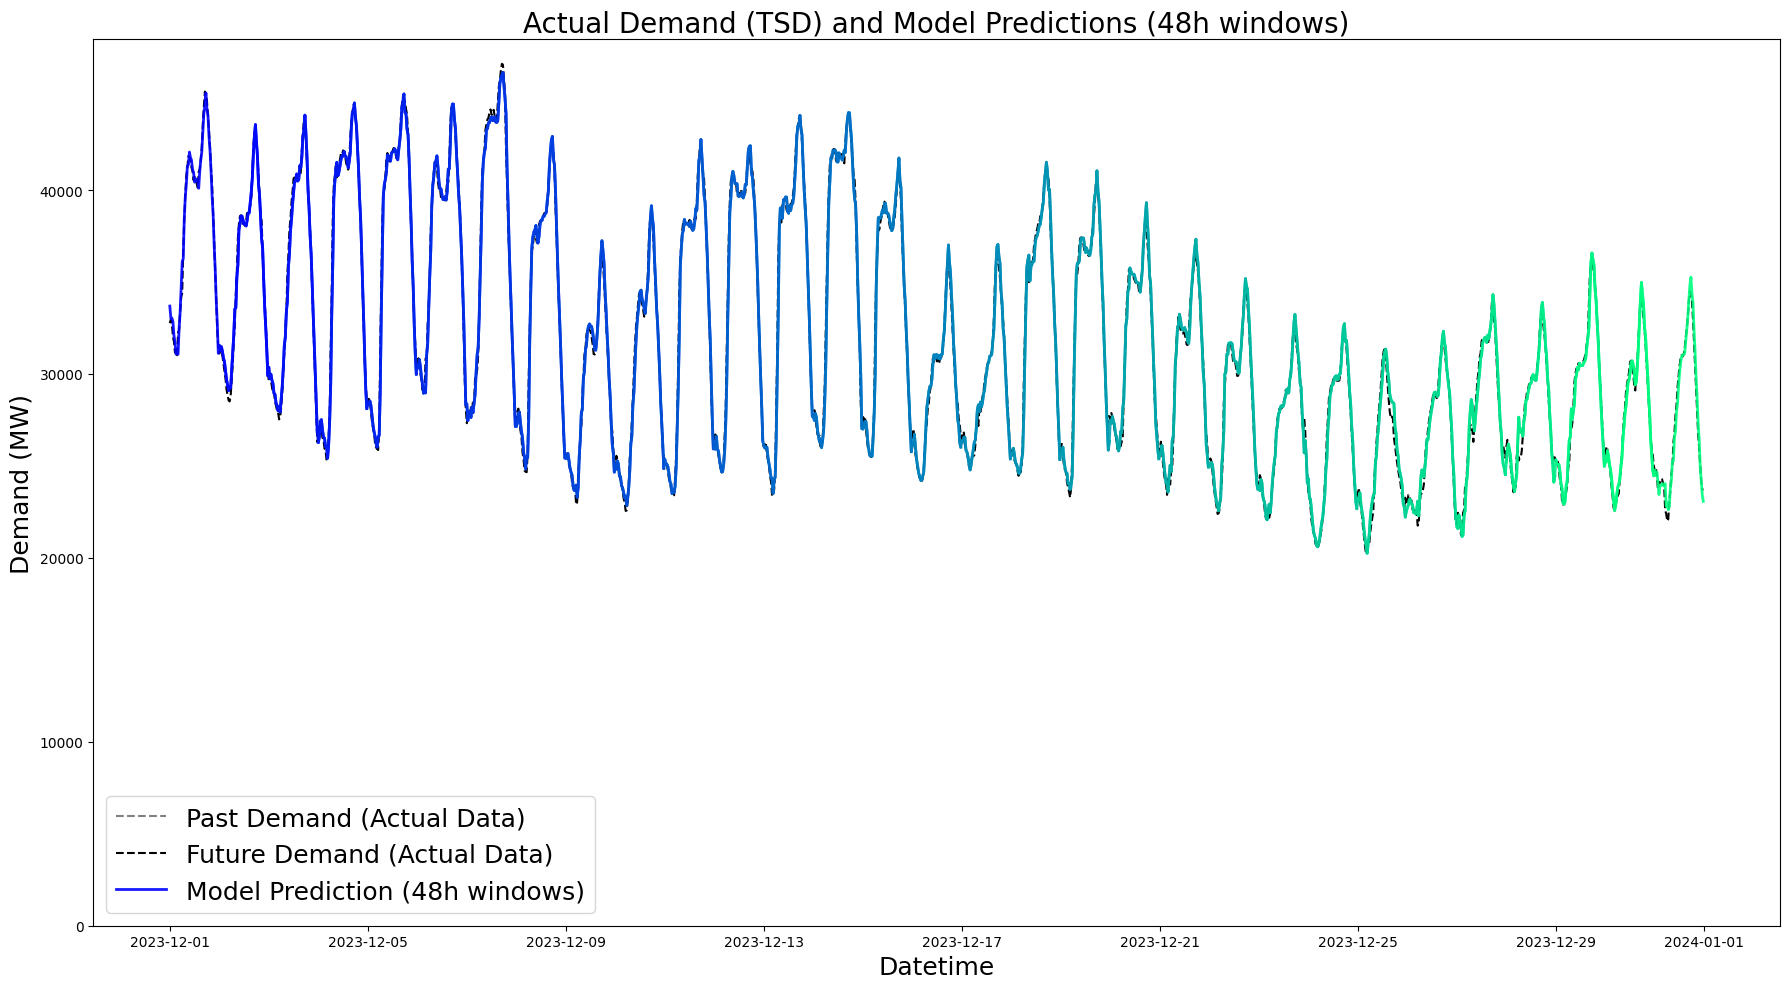

Test RMSE: 524.50 MW


In [23]:
# Machine Learning Model: GradientBoostingRegressor with 5 features

import matplotlib.cm as cm
import numpy as np
from datetime import datetime
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error

# Prepare features for ML
df_ml = (
    df.with_columns([
        pl.col("datetime"),
        pl.col("tsd"),
        pl.col("datetime").dt.ordinal_day().alias("day_of_year"),  # 1-366
        pl.col("datetime").dt.weekday().alias("day_of_week"),      # 0=Monday, 6=Sunday
        pl.col("datetime").dt.hour().alias("hour"),     
        pl.col("tsd").shift(1).alias("demand_lag_30m"),
        pl.col("tsd").shift(48).alias("demand_lag_24h"),
    ])
)

# Define test period
train_start = datetime(2020, 1, 1, 0, 0)
test_start = datetime(2023, 12, 1, 0, 0)
test_end = datetime(2023, 12, 31, 23, 59)

# Get the full actual data for plotting (from 1st Dec to test_end)
plot_start = datetime(2023, 12, 1, 0, 0)
plot_end = test_end

actual_past_mask = (df_ml["datetime"] >= plot_start) & (df_ml["datetime"] < test_start)
actual_past_times = df_ml.filter(actual_past_mask)["datetime"].to_pandas()
actual_past_tsd = df_ml.filter(actual_past_mask)["tsd"].to_numpy()

actual_future_mask = (df_ml["datetime"] >= test_start) & (df_ml["datetime"] <= test_end)
actual_future_times = df_ml.filter(actual_future_mask)["datetime"].to_pandas()
actual_future_tsd = df_ml.filter(actual_future_mask)["tsd"].to_numpy()

plt.figure(figsize=(18, 10))
plt.plot(actual_past_times, actual_past_tsd, label="Past Demand (Actual Data)", color="grey", linestyle='--', zorder=1)
plt.plot(actual_future_times, actual_future_tsd, label="Future Demand (Actual Data)", color="black", linestyle='--', zorder=1)

# --- Model predictions (GradientBoostingRegressor) ---
features = ["demand_lag_30m", "demand_lag_24h", "day_of_year", "day_of_week", "hour"]
target = "tsd"
X = df_ml.select(features)
y = df_ml.select(target)

results = []
prediction_handle = []

# Count how many 48h windows fit in the test period with 24h step to set colormap
rolling_test_start = test_start
window_count = 0

while rolling_test_start + pd.Timedelta(hours=24) < test_end:
    window_count += 1
    rolling_test_start += pd.Timedelta(hours=24)


print ("Number of 48h windows in test period:", window_count)
rolling_test_start = test_start
cmap = cm.get_cmap('winter', window_count)
i = 0
prediction_handle = None


train_mask = (df_ml["datetime"] > train_start) & (df_ml["datetime"] < test_start)
X_train = X.filter(train_mask).to_pandas()
y_train = y.filter(train_mask).to_numpy().ravel()


model = GradientBoostingRegressor(
        n_estimators=100, max_depth=5, learning_rate=0.05, validation_fraction=0.2, random_state=7
    )
model.fit(X_train, y_train)

while rolling_test_start + pd.Timedelta(hours=24) <= test_end:
    train_mask = (df_ml["datetime"] > train_start) & (df_ml["datetime"] < test_start)
    test_mask = (df_ml["datetime"] >= rolling_test_start) & (df_ml["datetime"] < rolling_test_start + pd.Timedelta(hours=48))
    X_test = X.filter(test_mask).to_pandas()
    y_test = y.filter(test_mask).to_numpy().ravel()
    times = df_ml.filter(test_mask)["datetime"].to_numpy()

    if len(X_test) == 0:
        break
    
    y_pred = model.predict(X_test)
    rmse = root_mean_squared_error(y_test, y_pred)
    results.append({"test_start": rolling_test_start, "rmse": rmse})
    # Plot and capture handle for legend
    if i == 0:
        prediction_handle, = plt.plot(times, y_pred, color=cmap(i), linewidth=2, alpha=0.9, zorder=2, label="Prediction")
    else:
        plt.plot(times, y_pred, color=cmap(i), linewidth=2, alpha=0.9, zorder=2)
    rolling_test_start += pd.Timedelta(hours=24)
    i += 1

# Custom legend
handles = [
    plt.Line2D([], [], color="grey", linestyle='--', label="Past Demand (Actual Data)"),
    plt.Line2D([], [], color="black", linestyle='--', label="Future Demand (Actual Data)"),
    prediction_handle
]
labels = [
    "Past Demand (Actual Data)",
    "Future Demand (Actual Data)",
    "Model Prediction (48h windows)"
]
plt.legend(handles, labels, loc='lower left', fontsize=18)
plt.title("Actual Demand (TSD) and Model Predictions (48h windows)", fontsize=20)
plt.ylim(bottom=0)
plt.xlabel("Datetime", fontsize=18)
plt.ylabel("Demand (MW)", fontsize=18)
plt.tight_layout()
plt.show()

# Print results DataFrame
results_ML_extra_features = pd.DataFrame(results)
print(f"Test RMSE: {results_ML_extra_features['rmse'].mean():.2f} MW")


In [48]:
import plotly.graph_objects as go

# Make x axis go from 1 to 31 (all December days)
x_days = list(range(1, 32))

# Prepare y values for each model, filling missing days with None for gaps
def fill_rmse_by_day(results_df):
    rmse_by_day = {d.day: v for d, v in zip(results_df["test_start"], results_df["rmse"])}
    return [rmse_by_day.get(day, None) for day in x_days]

y_7d = fill_rmse_by_day(results_7_day_mean)
y_ML = fill_rmse_by_day(results_ML)
y_extra = fill_rmse_by_day(results_ML_extra_features)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=x_days,
    y=y_7d,
    mode='lines+markers',
    name='Baseline: 7-day mean',
    line=dict(color='#ff7f0e')
))
fig.add_trace(go.Scatter(
    x=x_days,
    y=y_ML,
    mode='lines+markers',
    name='GBR',
    line=dict(color='#bcbd22')
))
fig.add_trace(go.Scatter(
    x=x_days,
    y=y_extra,
    mode='lines+markers',
    name='GBR with extra features',
    line=dict(color='#2ca02c')
))

fig.update_layout(
    title="Comparison of different energy demand forecasting methods for December 2023 in the UK",
    xaxis_title="Day of December",
    yaxis_title="RMSE (MW)",
    plot_bgcolor='whitesmoke',
    legend=dict(
        font=dict(size=18),
        x=1,
        y=1,
        xanchor='right',
        yanchor='top'
    ),
    title_font=dict(size=20),
    title_x=0.5,
    xaxis=dict(
        tickmode='linear',
        tick0=1,
        dtick=1,
        range=[0.1, 31],
        tickfont=dict(size=16),
        title_font=dict(size=18)
    ),
    yaxis=dict(
        range=[0, 6999],
        tickfont=dict(size=16), 
        title_font=dict(size=18)
        ),
    width=1100,
    height=500
)

fig.show()